In [1]:
# Aggregate the results and generate a plot
#
# Authors: Parisa Zahedi, Jonathan de Bruin
#
# Dependencies: sklearn, numpy
# License: BSD-3-Clause

# pylint: disable=C0321

import os
import re
import glob
import warnings
import sklearn

from sklearn import metrics
from scipy import stats
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


In [2]:
dataset_name ="ptsd"
#dataset_name ="ProtonPumpInhibitors"
#dataset_name = "BetaBlockers"
#dataset_name ="CalciumChannelBlockers"
#dataset_name = "Opiods"
#dataset_name = "ACEInhibitors"
#dataset_name = "AtypicalAntipsychotics"
#dataset_name = "Statins"

In [3]:
def get_threshholds(pred):
        desc = stats.describe(pred)
        (min_prob, max_prob) = desc.minmax
        print('min_prob,max_prob', min_prob, max_prob)
        step = (max_prob - min_prob) / 25
        threshholds = [i for i in np.arange(max_prob, min_prob - step, -step)]
        threshholds += [min_prob]
        return threshholds

def get_scores_threshhold(pred, label, threshhold):
        y_classes = ([0 if x < float(threshhold) else 1 for x in pred])
        (tn, fp, fn, tp) = sklearn.metrics.confusion_matrix(label, y_classes).ravel()
        return (tn, fp, fn, tp)
def get_scores(pred, label, allowed_FN):
        threshholds = get_threshholds(pred)
        best_tn, best_fp, best_fn, best_tp = get_scores_threshhold(
            pred, label, threshholds[0])
        ## calculate scores for each threshhold
        for i, threshhold in enumerate(threshholds):
            tn, fp, fn, tp = get_scores_threshhold(
                pred, label, threshhold)
            if (fn <= allowed_FN) and (best_fn > allowed_FN) and (threshhold >0):
                best_tn = tn
                best_fp = fp
                best_fn = fn
                best_tp = tp
            else:  #when fn meets the requirement, we select a smaller threshhold just when it decreases fp.
                if (fn <= allowed_FN) and (best_fp > fp) and (threshhold > 0):
                    best_tn = tn
                    best_fp = fp
                    best_fn = fn
                    best_tp = tp
        return (float(best_tn), float(best_fp), float(best_fn), float(best_tp))

# list(map (lambda lb,pr: get_scores(pr, lb, 1),df.iloc[:,1],df.iloc[:,2]))

def get_score_iterations(df, sample_no,q):
    col_no = len(df.columns)
    scores = list()
    col_names = df.columns.values.tolist()
    for i in np.arange(2,col_no):
        df_ = df.loc[df[col_names[i]] != -1]
        (tn,fp,fn,tp)=get_scores(df_.iloc[:,i], df_.iloc[:,1], 1)  
        scores.append([sample_no, i-1, tn,fp,fn,tp,q])
    return scores

In [ ]:
##Run once
# # store the result
# column_names = ['sample','iteration','tn','fp','fn','tp','q']

# sample_no =0
# scores= list()

# # save the result to a file
# for q in ('lc','random'):
#     for fp in glob.glob(os.path.join('..','output','active_learning',dataset_name, 'dataset_{}_sr_lstm_active*_q_{}.csv'.format(dataset_name,q))):
#         sample_no +=1 
#         with open(fp) as csv_file:
#             # load the result into memory 
#             df = pd.read_csv(fp)
#         score_sample = get_score_iterations(df, sample_no,q) 
#         scores +=score_sample
        
# scores_df = pd.DataFrame.from_records(scores, columns=column_names)
# scores_df.to_csv(os.path.join('..', 'output','active_learning',dataset_name, 'sr_lstm_results.csv'))

In [12]:
# dataset_name ="BetaBlockers"
init_paper =20
batch_size = 10
df_results = pd.read_csv(os.path.join('..', 'output','active_learning',dataset_name, 'sr_lstm_results.csv')) #, index_col='sample'
    
df_results['recall'] = df_results['tp']/(df_results['tp']+df_results['fn'])
df_results['fp_rate'] = df_results['fp']/(df_results['fp']+df_results['fn'])

df_results['to_read_plus_train_number'] = (df_results['fp']+df_results['tp']+(df_results['iteration']* batch_size)+init_paper)
df_results['to_read_plus_train_rate'] = df_results['to_read_plus_train_number']/(df_results['fp']+df_results['fn']+df_results['tp']+df_results['tn']+(df_results['iteration']* batch_size)+init_paper)

df_results['to_read_number'] = (df_results['fp']+df_results['tp'])
df_results['to_read_rate'] = df_results['to_read_number']/(df_results['fp']+df_results['fn']+df_results['tp']+df_results['tn'])    

In [13]:
df= df_results.loc[df_results['q']=='random',['sample','iteration','to_read_plus_train_number']]
df_random = df.pivot(index='iteration',columns='sample',values='to_read_plus_train_number')

df_random['mean']=df_random.mean(axis=1)


df= df_results.loc[df_results['q']=='lc',['sample','iteration','to_read_plus_train_number']]
df_lc = df.pivot(index='iteration',columns='sample',values='to_read_plus_train_number')
df_lc['mean']=df_lc.mean(axis=1)

df_lc.loc[[1,49],:]

sample,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,mean
iteration,,,,,,,,,,,,,,,,,,,,,
1,5028.0,4479.0,4953.0,4521.0,5005.0,5030.0,4938.0,5051.0,4993.0,4598.0,...,5000.0,4845.0,5079.0,5015.0,4905.0,4846.0,4056.0,4792.0,4365.0,4803.01
49,5093.0,4584.0,5009.0,4668.0,5054.0,5062.0,4767.0,5092.0,5040.0,4670.0,...,4792.0,4954.0,5128.0,5062.0,4963.0,4927.0,4180.0,4841.0,4466.0,4862.92


## Visualize training size and initial included papers

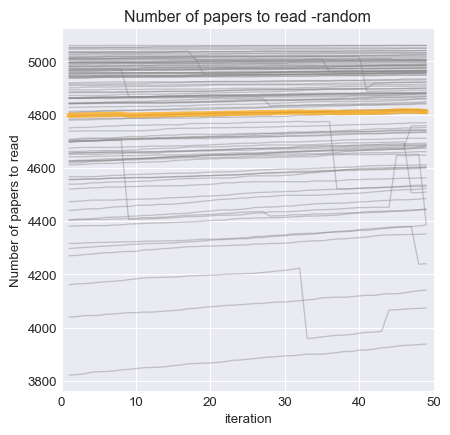

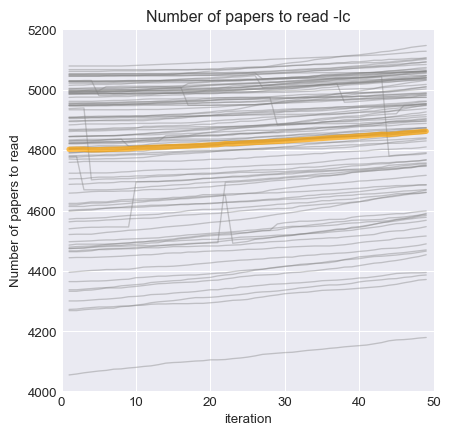

In [15]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
# multiple line plot
for column in df_random:
        plt.plot(df_random.index, df_random[column], marker='', color='gray', linewidth=1, alpha=0.4)

plt.plot(df_random.index, df_random['mean'], marker='', color= 'orange', linewidth=4, alpha=0.7)
plt.xlim(0,50)
plt.xlabel('iteration')
plt.ylabel('Number of papers to read')
plt.title('Number of papers to read -random')



plt.show()

###################
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

for column in df_lc:
        plt.plot(df_lc.index, df_lc[column], marker='', color='gray',  linewidth=1, alpha=0.4)

plt.plot(df_lc.index, df_lc['mean'], marker='', color= 'orange', linewidth=4, alpha=0.7)

plt.xlim(0,50)
plt.xlabel('iteration')
plt.ylabel('Number of papers to read')
plt.title('Number of papers to read -lc')

plt.show()


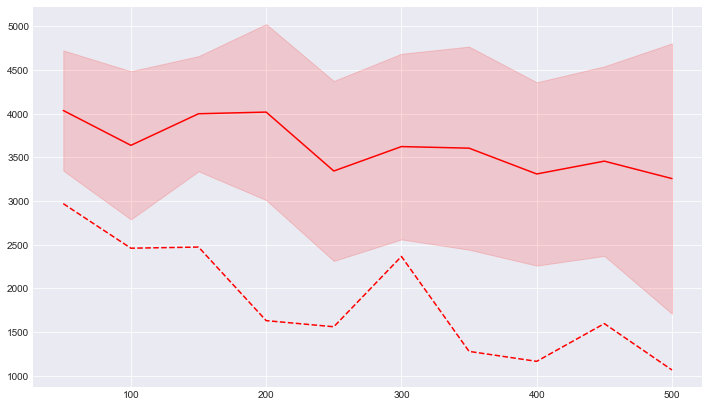

In [7]:
# selected_col_names = ['training_size','allowed_FN','init_included_papers','dataset','fp_rate','recall','to_read_number','to_read_rate','tn','fp','fn','tp']
df_results = pd.read_csv(os.path.join('..', 'output','passive',dataset_name, 'ptsd_results.csv'))
    
df_results['to_read_plus_train_number'] = (df_results['fp']+df_results['tp']+df_results['training_size'])
df_results['to_read_plus_train_rate'] = df_results['to_read_plus_train_number']/(df_results['fp']+df_results['fn']+df_results['tp']+df_results['tn']+df_results['training_size'])

cond = (df_results['allowed_FN'] == 1) & (df_results['dropout'] == 0.4) & (df_results['init_included_papers'] == 10)
df_pas = df_results.loc[cond,]
df_pas

fig, ax = plt.subplots(figsize=(12, 7))
m = df_pas.groupby(['training_size','init_included_papers']).mean()['to_read_plus_train_number'].unstack()
st = df_pas.groupby(['training_size','init_included_papers']).std()['to_read_plus_train_number'].unstack()
min_ = df_pas.groupby(['training_size','init_included_papers']).min()['to_read_plus_train_number'].unstack()


s=10
ax.plot(m.index, m[s], 'r', label=s)
ax.fill_between(m.index, m[s] - st[s], m[s] + st[s], color='r', alpha=0.15)
ax.plot(m.index, min_[s], "{}--".format('r', alpha=0.5, label="min of {}".format(s)))
plt.show()






#     if not os.path.isdir(os.path.join('..', 'output', 'figures', dataset_name)):
#         os.mkdir(os.path.join('..', 'output', 'figures', dataset_name))
#     fig.savefig(os.path.join('..','output', "figures", dataset_name, "perf_plot-{}_{}.png".format(r,dataset_name)))